In [53]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # (giữ lại nếu muốn augment ảnh trước DCT)
from tensorflow.keras.optimizers import Adamax  # dùng Adamax như code của bạn

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Khác
from collections import defaultdict
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from tfkan.layers import DenseKAN  # giữ nguyên như bạn
from scipy.fft import dctn        # DCT 2D với norm='ortho'


In [54]:
# Define the path to the dataset
base_path = '/Applications/Tien/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [55]:
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df['video_key'] = df['id'].astype(str) + "_" + df['label']


In [56]:
# =========================
# Group theo video_key + sort frame
# =========================
video_dict = defaultdict(list)
labels = {}

# sort theo (video_key, frame) để đảm bảo thứ tự thời gian
df_sorted = df.sort_values(by=['video_key', 'frame'])
for _, row in df_sorted.iterrows():
    key = row['video_key']
    video_dict[key].append((row['frame'], row['path']))  # lưu kèm số frame
    labels[key] = row['label_id']

# Sau khi build xong, chỉ để lại list đường dẫn (đã sort sẵn)
for k in video_dict:
    video_dict[k] = [p for _, p in video_dict[k]]


In [57]:
!pip install opencv-python

In [58]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN  # Import KAN layers
from scipy.stats import mode
from tensorflow.keras.applications import EfficientNetB0


# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# =========================
# DCT utilities (ONLY DCT)
# =========================
def compute_dct_bands(img_bgr, img_size=(224, 224), low_sz=32, mid_sz=96, augment=False):
    """
    Chuyển ảnh BGR → Gray → DCT-2D (ortho) → log-magnitude.
    Cắt 3 băng tần (low/mid/high), resize về img_size và concat thành 3 kênh.
    """
    # optional augment "trước DCT": blur/noise nhẹ (hợp lý cho miền tần số)
    if augment:
        # Gaussian blur nhẹ xác suất 0.5
        if np.random.rand() < 0.5:
            k = np.random.choice([3,5])
            img_bgr = cv2.GaussianBlur(img_bgr, (k, k), 0)
        # Gaussian noise nhẹ xác suất 0.5
        if np.random.rand() < 0.5:
            noise = np.random.normal(0, 5, img_bgr.shape).astype(np.float32)
            img_bgr = np.clip(img_bgr.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # To gray & resize
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, img_size, interpolation=cv2.INTER_AREA).astype(np.float32)

    # Chuẩn hóa 0..1
    gray = gray / 255.0

    # DCT-2D với chuẩn hóa ortho
    # dctn áp dụng DCT theo 2 trục (H,W)
    X = dctn(gray, type=2, norm='ortho')

    # Log-magnitude để nén động
    X = np.log1p(np.abs(X))  # (H,W)

    H, W = X.shape
    low_sz = min(low_sz, H, W)
    mid_sz = min(mid_sz, H, W)

    # Low band: góc trái trên (0:low_sz, 0:low_sz)
    low = np.zeros_like(X)
    low[:low_sz, :low_sz] = X[:low_sz, :low_sz]

    # Mid band: vòng đai giữa (0:mid_sz, 0:mid_sz) trừ phần low
    mid = np.zeros_like(X)
    mid[:mid_sz, :mid_sz] = X[:mid_sz, :mid_sz]
    mid[:low_sz, :low_sz] = 0  # loại low ra

    # High band: phần còn lại
    high = X.copy()
    high[:mid_sz, :mid_sz] = 0

    # Resize từng band về img_size để ghép thành 3 kênh
    low_r  = cv2.resize(low,  img_size, interpolation=cv2.INTER_LINEAR)
    mid_r  = cv2.resize(mid,  img_size, interpolation=cv2.INTER_LINEAR)
    high_r = cv2.resize(high, img_size, interpolation=cv2.INTER_LINEAR)

    # Chuẩn hóa kênh (z-score theo ảnh) để tránh scale lệch (ổn định hơn)
    def zscore(a, eps=1e-6):
        m, s = a.mean(), a.std()
        return (a - m) / (s + eps)

    low_r  = zscore(low_r)
    mid_r  = zscore(mid_r)
    high_r = zscore(high_r)

    dct_3ch = np.stack([low_r, mid_r, high_r], axis=-1).astype(np.float32)  # (H,W,3)
    return dct_3ch

# =========================
# Data generator → DCT
# =========================
class VideoSequence(tf.keras.utils.Sequence):
    """
    Trả (B, T, H, W, 3) với 3 kênh là băng tần DCT (low/mid/high).
    """
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            # lấy max T frame đầu (đã sort ở phần build video_dict)
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img_bgr = cv2.imread(path)  # BGR
                if img_bgr is None:
                    # pad nếu ảnh lỗi
                    dct_3ch = np.zeros((*self.img_size, 3), dtype=np.float32)
                else:
                    dct_3ch = compute_dct_bands(
                        img_bgr, img_size=self.img_size,
                        low_sz=32, mid_sz=96,
                        augment=self.augment
                    )
                imgs.append(dct_3ch)

            # pad nếu clip ngắn hơn T
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))

            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# =========================
# Model: MobileNetV2 (frozen) + LSTM + DenseKAN (y như bạn)
# =========================
def build_model(sequence_len, img_size):
    # Backbone nhận 3 kênh (low/mid/high) nên vẫn shape (H,W,3)
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = False  # freeze để giảm overfit khi đổi miền

    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    x = DenseKAN(1)(x)
    output = tf.keras.activations.sigmoid(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# HMM cải tiến
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# =========================
# Training K-Fold (giữ nguyên cấu trúc)
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen   = VideoSequence(val_keys,   video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen  = VideoSequence(test_keys,  video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop  = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.44828, saving model to best_model_fold1.h5
25/25 [==============================] - 47s 2s/step - loss: 0.7010 - accuracy: 0.5026 - val_loss: 0.6951 - val_accuracy: 0.4483 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.5051
Epoch 2: val_accuracy improved from 0.44828 to 0.48276, saving model to best_model_fold1.h5
25/25 [==============================] - 46s 2s/step - loss: 0.6978 - accuracy: 0.5051 - val_loss: 0.6957 - val_accuracy: 0.4828 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5218
Epoch 3: val_accuracy did not improve from 0.48276
25/25 [==============================] - 55s 2s/step - loss: 0.6955 - accuracy: 0.5218 - val_loss: 0.6951 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5513
Epoch 4: val_accuracy did not improve from 0.48276
25/25 [==============================] - 64s 3s/step - loss: 0.6906 - accuracy: 0.5513 - val_loss: 0.6949 - val_accuracy: 0.4368 - lr: 5.0000e-05
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5321
Epo

/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.5231
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fold2.h5
25/25 [==============================] - 72s 3s/step - loss: 0.7021 - accuracy: 0.5231 - val_loss: 0.6859 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.4987
Epoch 2: val_accuracy improved from 0.56322 to 0.66667, saving model to best_model_fold2.h5
25/25 [==============================] - 63s 3s/step - loss: 0.6998 - accuracy: 0.4987 - val_loss: 0.6845 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.5115
Epoch 3: val_accuracy did not improve from 0.66667
25/25 [==============================] - 77s 3s/step - loss: 0.7031 - accuracy: 0.5115 - val_loss: 0.6852 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5013
Epoch 4: val_accuracy did not improve from 0.66667
25/25 [==============================] - 73s 3s/step - loss: 0.6981 - accuracy: 0.5013 - val_loss: 0.6833 - val_accuracy: 0.6437 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.5115
Epo

/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.4808
Epoch 1: val_accuracy improved from -inf to 0.47126, saving model to best_model_fold3.h5
25/25 [==============================] - 86s 3s/step - loss: 0.7076 - accuracy: 0.4808 - val_loss: 0.6959 - val_accuracy: 0.4713 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5154
Epoch 2: val_accuracy did not improve from 0.47126
25/25 [==============================] - 83s 3s/step - loss: 0.6974 - accuracy: 0.5154 - val_loss: 0.6986 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.5000
Epoch 3: val_accuracy improved from 0.47126 to 0.48276, saving model to best_model_fold3.h5
25/25 [==============================] - 91s 4s/step - loss: 0.7017 - accuracy: 0.5000 - val_loss: 0.6999 - val_accuracy: 0.4828 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5474
Epoch 4: val_accuracy did not improve from 0.48276
25/25 [==============================] - 80s 3s/step - loss: 0.6896 - accuracy: 0.5474 - val_loss: 0.6985 - val_accuracy: 0.4713 - lr: 5.0000e-05
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.4769
Epo

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7147 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.50575, saving model to best_model_fold4.h5
25/25 [==============================] - 66s 3s/step - loss: 0.7147 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5218
Epoch 2: val_accuracy did not improve from 0.50575
25/25 [==============================] - 64s 3s/step - loss: 0.6990 - accuracy: 0.5218 - val_loss: 0.6930 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.50575
25/25 [==============================] - 64s 3s/step - loss: 0.7040 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.5013
Epoch 4: val_accuracy did not improve from 0.50575
25/25 [==============================] - 66s 3s/step - loss: 0.7002 - accuracy: 0.5013 - val_loss: 0.6924 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.5115
Epoch 5: val_accuracy did not improve from 0

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.4994
Epoch 1: val_accuracy improved from -inf to 0.45977, saving model to best_model_fold5.h5
25/25 [==============================] - 71s 3s/step - loss: 0.7104 - accuracy: 0.4994 - val_loss: 0.6971 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 2/50


/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5237
Epoch 2: val_accuracy improved from 0.45977 to 0.49425, saving model to best_model_fold5.h5
25/25 [==============================] - 68s 3s/step - loss: 0.6960 - accuracy: 0.5237 - val_loss: 0.6982 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.5109
Epoch 3: val_accuracy did not improve from 0.49425
25/25 [==============================] - 65s 3s/step - loss: 0.6957 - accuracy: 0.5109 - val_loss: 0.7030 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.4891
Epoch 4: val_accuracy did not improve from 0.49425
25/25 [==============================] - 65s 3s/step - loss: 0.6962 - accuracy: 0.4891 - val_loss: 0.7030 - val_accuracy: 0.4943 - lr: 5.0000e-05
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.4840
Epo

/Applications/Tien/deepfake-models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.698464
precision    0.811686
recall       0.594224
f1           0.560690
auc          0.646222
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,1.000000,0.018519,0.036364,0.575008
1,2,0.940092,1.000000,0.879630,0.935961,0.693255
2,3,0.534562,0.681818,0.137615,0.229008,0.527438
3,4,0.672811,0.607955,0.981651,0.750877,0.688753
4,5,0.833333,0.768657,0.953704,0.851240,0.746656


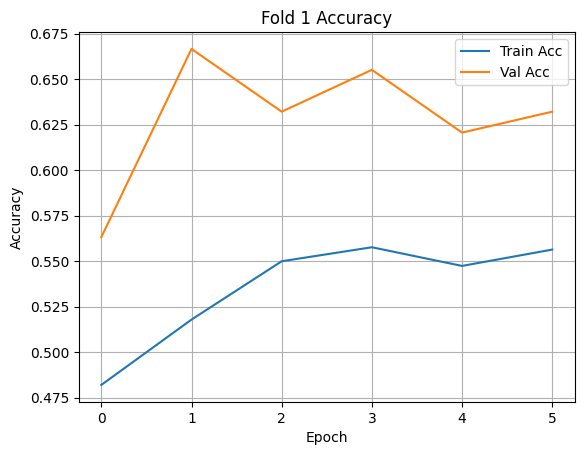

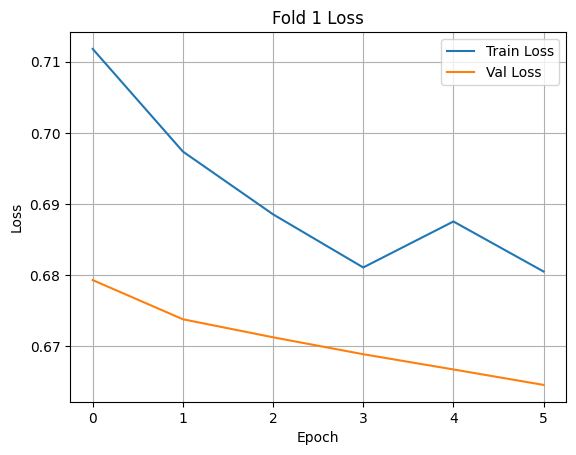

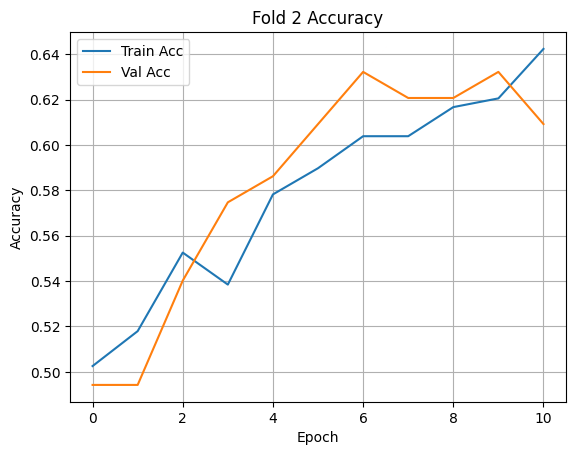

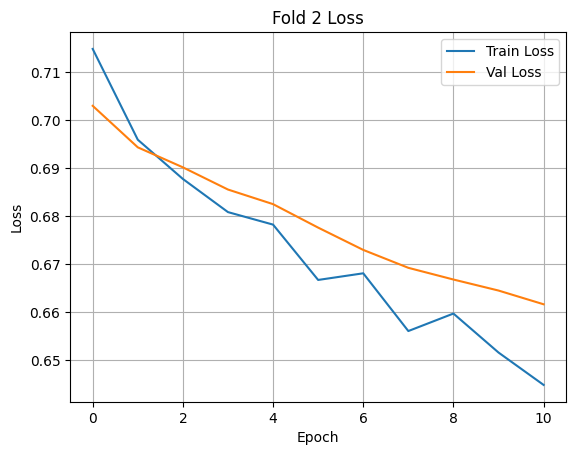

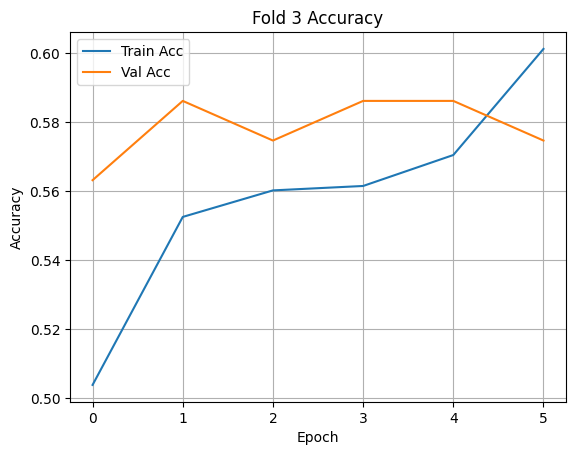

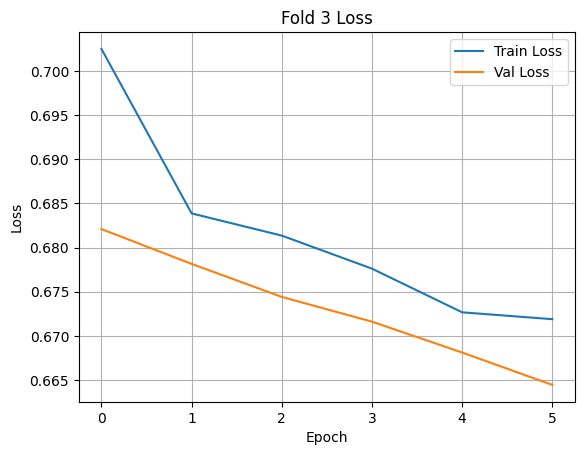

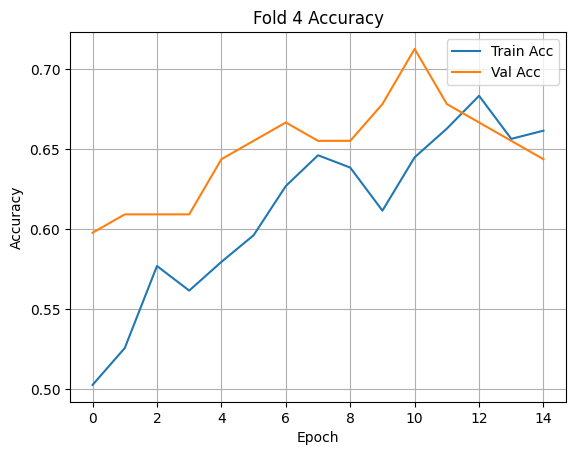

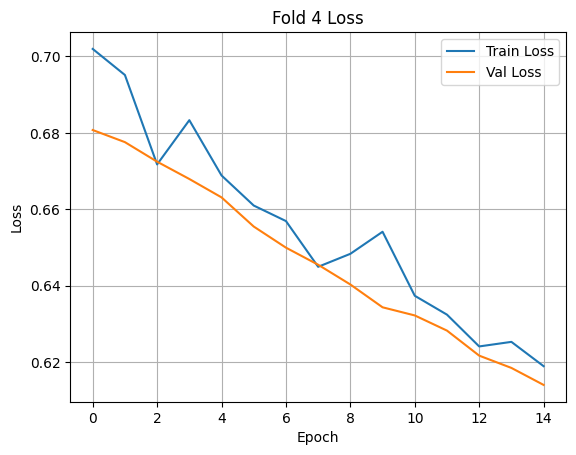

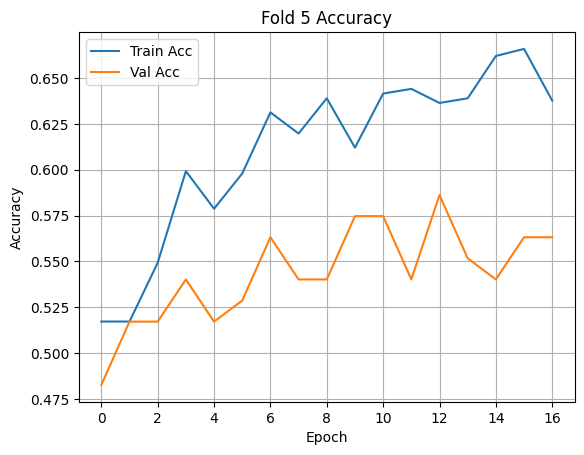

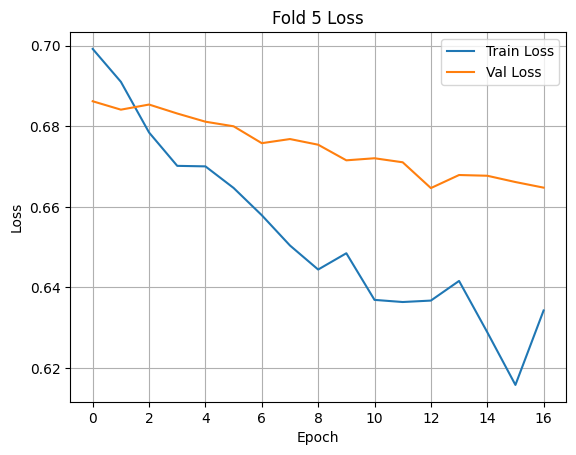

In [8]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [40]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_dct_hmm_final.h5")


In [10]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.698464
precision    0.811686
recall       0.594224
f1           0.560690
auc          0.646222
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,1.000000,0.018519,0.036364,0.575008
1,2,0.940092,1.000000,0.879630,0.935961,0.693255
2,3,0.534562,0.681818,0.137615,0.229008,0.527438
3,4,0.672811,0.607955,0.981651,0.750877,0.688753
4,5,0.833333,0.768657,0.953704,0.851240,0.746656


In [11]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.698464
precision    0.811686
recall       0.594224
f1           0.560690
auc          0.646222
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6985
📈 Range Accuracy: 0.4286
📉 Accuracy CV% (std/mean): 26.69%


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,1.000000,0.018519,0.036364,0.575008
1,2,0.940092,1.000000,0.879630,0.935961,0.693255
2,3,0.534562,0.681818,0.137615,0.229008,0.527438
3,4,0.672811,0.607955,0.981651,0.750877,0.688753
4,5,0.833333,0.768657,0.953704,0.851240,0.746656
